# Predict Prices of Used Cars
The goal of this project is to predict the price of cars based on data of the year, milage,brand, model, and location the car is from. The data is taken from kaggle.com: https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions

In [212]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# set plot style
plt.style.use('ggplot')

In [213]:
# import data
df = pd.read_csv("true_car_listings.csv")

# EDA

Perform EDA on the data to understand the features better.

In [214]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [215]:
df.dtypes

Price       int64
Year        int64
Mileage     int64
City       object
State      object
Vin        object
Make       object
Model      object
dtype: object

In [216]:
df['State'] = df['State'].astype('category')
df['City'] = df['City'].astype('category')
df['Vin'] = df['Vin'].astype('category')

In [217]:
df.dtypes

Price         int64
Year          int64
Mileage       int64
City       category
State      category
Vin        category
Make         object
Model        object
dtype: object

In [218]:
# check for nulls
df.isna().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [219]:
# remove extra space from State var
df['State'] = [x.strip() for x in df['State']]

Looking at the category State we see that some States have recorded more Sales than others. For example, the dataset contains more sales from Texas than New York.

Text(0.5, 1.0, 'Cars Sold in Each State')

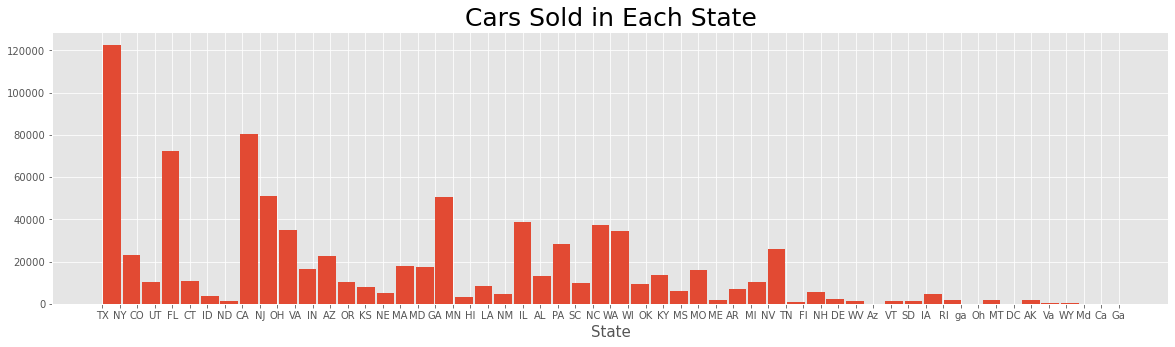

In [220]:
# look at the categorical variables
plt.figure(figsize=(20,5))
plt.hist(df['State'], bins = 52,rwidth=0.9)
plt.xlabel("State", fontsize = 15)
plt.title("Cars Sold in Each State", fontsize = 25)

In [221]:
len(df['Make'].unique())

58

Looking at Make we see that it represents the car brand, we can also see that some car brands are more prevalent in the dataset. 

Text(0.5, 1.0, 'Cars Sold From Each Make')

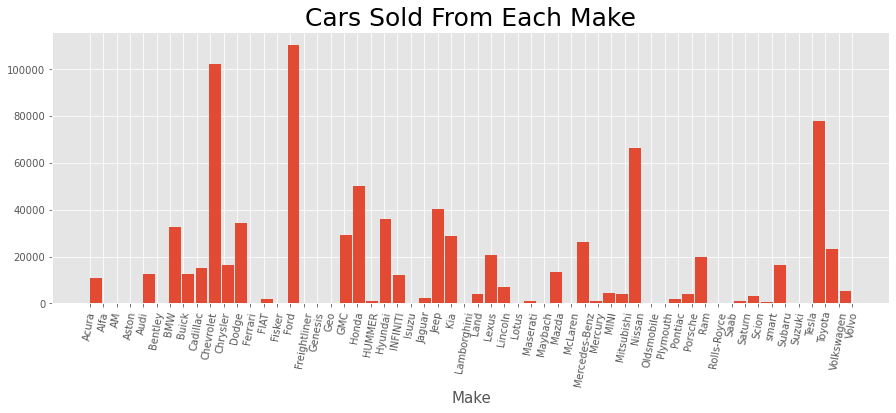

In [222]:
# look at the make category
plt.figure(figsize=(15,5))
plt.hist(df['Make'], bins = len(df['Make'].unique()), rwidth=0.9)
plt.xlabel("Make", fontsize = 15)
plt.xticks(rotation = 80)
plt.title("Cars Sold From Each Make", fontsize = 25)

Looking at City and Model we see that the number of unique values are more than 1000, which makes creating an histogram problematic. Instead we can look at a list of the number of observations seen per City and per Model and evaluate which City and Model are the most common one. In Conclusion, we can see that Houston and the model Silverando are the most prevalent in their respective columns. 

In [223]:
df['City'].value_counts(sort = True)

Houston          12703
San Antonio       8078
Louisville        5872
Jacksonville      5675
Austin            5297
                 ...  
Pen Argyl            4
Los Banos            4
Armona               4
Pleasant Hill        4
Royston              2
Name: City, Length: 2553, dtype: int64

In [224]:
df['Model'].value_counts(sort = True)

Silverado     24932
Grand         17321
Accord        14502
F-1504WD      14177
Altima2.5     11288
              ...  
Esteem4dr         1
Impala2           1
Patriot4x4        1
ViperACR          1
SedonaSX-L        1
Name: Model, Length: 2736, dtype: int64

What model is the most common per make?

In [225]:
# group data by make and count the models
df_modelMake = df.groupby(['Make','Model']).count()

In [226]:
print(df_modelMake.dtypes)

Price      int64
Year       int64
Mileage    int64
City       int64
State      int64
Vin        int64
dtype: object


In [227]:
#df[['Make', 'Model']].count()
df_modelMake = df_modelMake.unstack(level = 0).reset_index()

In [228]:
df_modelMake = df_modelMake.reset_index()

In [229]:
df_modelMake = df_modelMake.melt(id_vars = ["Model"]).dropna()

In [230]:
df_modelMake = df_modelMake.drop(columns = [None], axis = 1)

In [231]:
df_modelMake["Car"] = df_modelMake['Make']+ ": " + df_modelMake['Model']

In [232]:
df_modelMake = df_modelMake.loc[df_modelMake.groupby('Make')['value'].idxmax()].sort_values(by = 'value', ascending = False)

In [233]:
df_modelMake.head()

,Model,Make,value,Car
29510,Silverado,Chevrolet,24932.0,Chevrolet: Silverado
60438,Accord,Honda,14502.0,Honda: Accord
44682,F-1504WD,Ford,14177.0,Ford: F-1504WD
115162,Altima2.5,Nissan,11288.0,Nissan: Altima2.5
51396,Sierra,GMC,11208.0,GMC: Sierra


Text(0, 0.5, 'Amount')

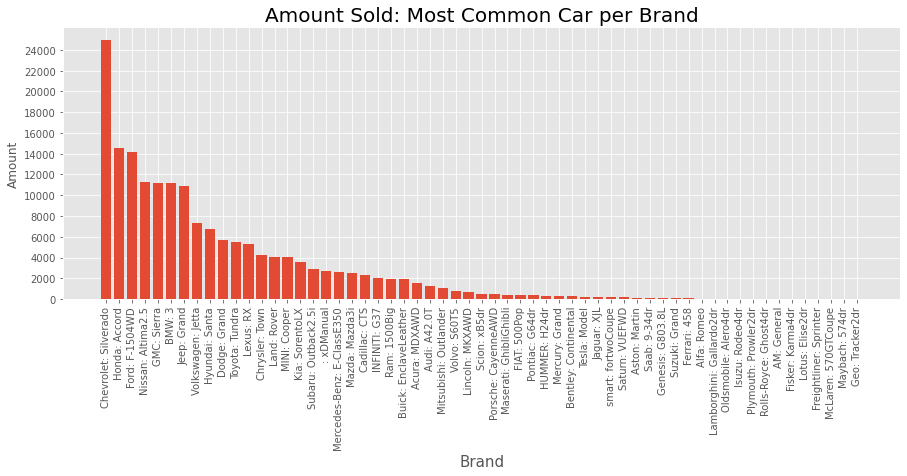

In [234]:

plt.figure(figsize=(15,5))
plt.bar(df_modelMake['Car'], df_modelMake['value'])
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, df_modelMake['value'].max(), 2000))
plt.title("Amount Sold: Most Common Car per Brand", fontsize = 20)
plt.xlabel("Brand", fontsize = 15)
plt.ylabel("Amount")


In [235]:
df['Make'] = df['Make'].astype('category')
df['Model'] = df['Model'].astype('category')

In [236]:
df.isna().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [237]:
df.dtypes
df['State'] = df['State'].astype('category')

Text(0, 0.5, 'Price')

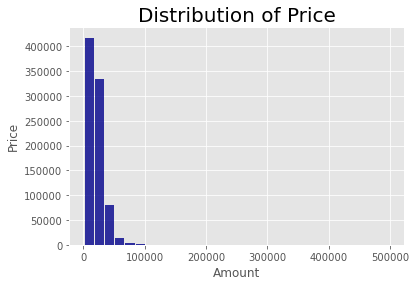

In [238]:
# Look at distribution of price
plt.hist(df['Price'], bins = 30, alpha=0.8, rwidth=0.9, color = 'darkblue')
plt.title("Distribution of Price", fontsize = 20)
plt.xlabel('Amount', fontsize = 12)
plt.ylabel("Price", fontsize = 12)

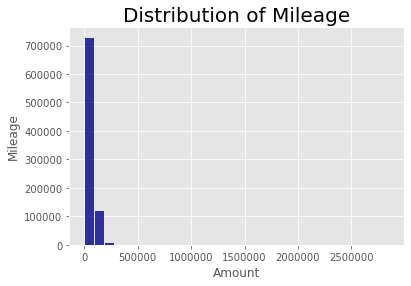

In [239]:
# look at distribution of mileage 
plt.hist(df['Mileage'], bins = 30, alpha=0.8, rwidth=0.9, color = 'darkblue')
plt.title("Distribution of Mileage", fontsize = 20)
plt.xlabel('Amount', fontsize = 12)
plt.ylabel("Mileage", fontsize = 12)
plt.ticklabel_format(style = 'plain')

In [240]:
# look at correlation between price and mileage
df['Price'].corr(df['Mileage']) # Pearson correlation

-0.4212368323745224

Text(0.5, 1.0, 'Correlations of Data')

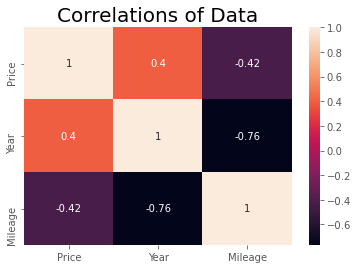

In [241]:
# create a correlation matrix
sns.heatmap(df.corr(), annot = True)
plt.title("Correlations of Data", fontsize = 20)

Text(0, 0.5, 'Average Price')

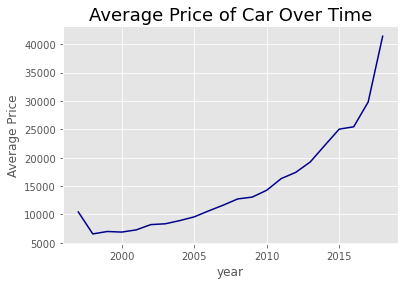

In [242]:
plt.plot(df['Price'].groupby(df['Year']).mean(), color = 'darkblue')
plt.title("Average Price of Car Over Time", fontsize = 18)
plt.xlabel("year")
plt.ylabel("Average Price")

Text(0.5, 0, 'Price')

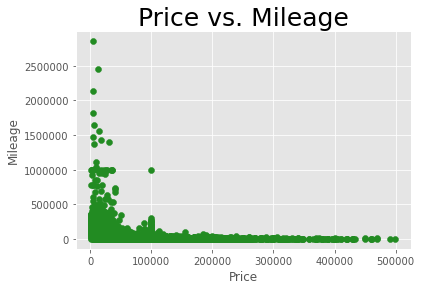

In [243]:
plt.scatter(df['Price'], df['Mileage'], color = 'forestgreen')
plt.title("Price vs. Mileage", fontsize = 25)
plt.ylabel('Mileage')
plt.ticklabel_format(style = 'plain')
plt.xlabel('Price')

Text(0.5, 1.0, 'Boxplot Price Data')

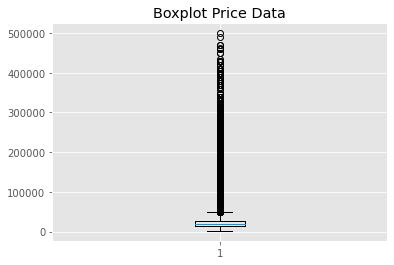

In [244]:
# make boxplot of price
plt.boxplot(df['Price'])
plt.title("Boxplot Price Data")

Text(0.5, 1.0, 'Boxplot Mileage Data')

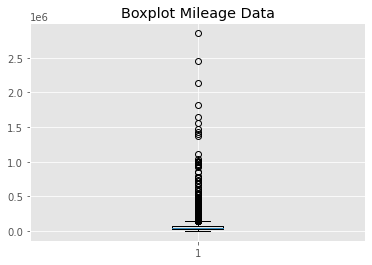

In [245]:
# make boxplot of mileage
plt.boxplot(df['Mileage'])
plt.title("Boxplot Mileage Data")

In [246]:
# remove outliers for price and mileage
# remove top 5% in each as it seems that outliers are higher not lower than most data
print(np.percentile(df['Price'], 95))
print(np.percentile(df['Mileage'], 95))

df = df[df['Price'] < np.percentile(df['Price'], 95)]

df = df[df['Mileage'] < np.percentile(df['Mileage'], 95)]

43300.0
134299.0


In [247]:
df.describe()

,Price,Year,Mileage
count,769034.000000,769034.000000,769034.000000
mean,20085.363020,2013.545898,47946.614133
std,8657.025384,3.019265,31779.317857
min,1500.000000,1997.000000,5.000000
25%,13582.000000,2013.000000,24218.000000
50%,18455.000000,2014.000000,39767.500000
75%,25989.000000,2016.000000,67700.000000
max,43299.000000,2018.000000,136030.000000


Text(0, 0.5, 'Price')

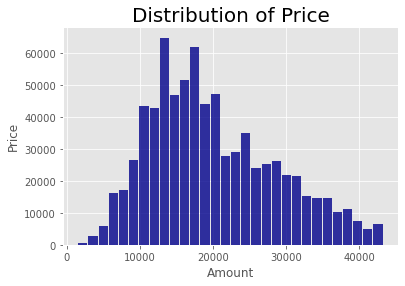

In [248]:
plt.hist(df['Price'], bins = 30, alpha=0.8, rwidth=0.9, color = 'darkblue')
plt.title("Distribution of Price", fontsize = 20)
plt.xlabel('Amount', fontsize = 12)
plt.ylabel("Price", fontsize = 12)

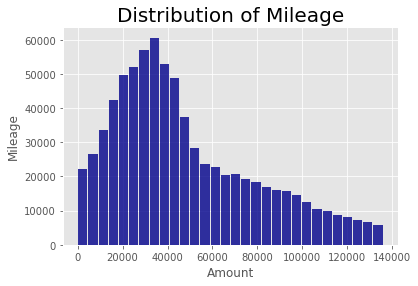

In [249]:
# look at distribution of mileage 
plt.hist(df['Mileage'], bins = 30, alpha=0.8, rwidth=0.9, color = 'darkblue')
plt.title("Distribution of Mileage", fontsize = 20)
plt.xlabel('Amount', fontsize = 12)
plt.ylabel("Mileage", fontsize = 12)
plt.ticklabel_format(style = 'plain')

Text(0.5, 0, 'Price')

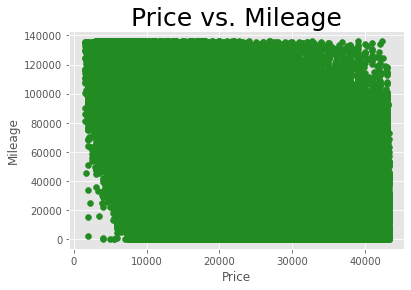

In [250]:
plt.scatter(df['Price'], df['Mileage'], color = 'forestgreen')
plt.title("Price vs. Mileage", fontsize = 25)
plt.ylabel('Mileage')
plt.ticklabel_format(style = 'plain')
plt.xlabel('Price')

Text(0.5, 0, 'Year')

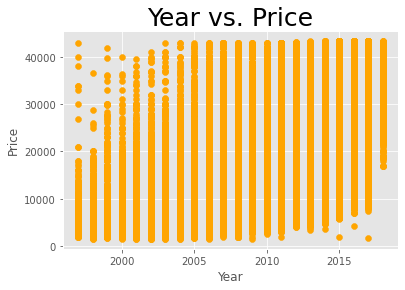

In [251]:
plt.scatter(df['Year'], df['Price'], color = 'orange')
plt.title("Year vs. Price", fontsize = 25)
plt.ylabel('Price')
plt.ticklabel_format(style = 'plain')
plt.xlabel('Year')

Text(0.5, 1.0, 'Correlations of Data')

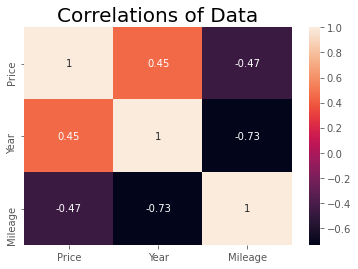

In [252]:
# look at correlation after outliers have been removed
# create a correlation matrix
sns.heatmap(df.corr(), annot = True)
plt.title("Correlations of Data", fontsize = 20)

# Data Processing

In [253]:
#combine make and model into one column car 
df["Car"] = df['Make'].astype(str)+ ": " + df['Model'].astype(str)
df["Car"] = df["Car"].astype('category')

In [254]:
#combine city and state
df['Location'] = df['State'].astype(str)+ ": " + df['City'].astype(str)
df['Location'] = df['Location'].astype('category')

In [255]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model,Car,Location
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed,Acura: ILX6-Speed,TX: El Paso
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed,Acura: ILX5-Speed,NY: Long Island City
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed,Acura: ILX6-Speed,TX: El Paso
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed,Acura: ILX5-Speed,CO: Windsor
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic,Acura: ILXAutomatic,UT: Lindon


In [256]:
x = df.drop(['Price'], axis = 1)
y = df['Price']
# train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [257]:
#print(x.loc[:0])

LabelEncoding and OrdinalEncoding encodes the data in a sequence (1,2,3,4..), whereas one hot encoding encodes the data as 1 or 0, with each category in the column as a new column. Thus one hot encoding creates a very sparse matrix. For ordinal data, label or ordinal encoding can be used. For cateogories that are not ordinal, however, one hot encoding is recommended. 

When doing Linear Regression for example categories should be encoded using one hot encoding unless they are ordinal. But, for Random Forrest the performance can get worse if using one hot encoding. Thus for Random Forrest Regression lable encoding is recommended for categorical variables. 

In [258]:
# label encode categorical variables
# FIX???
oe = OrdinalEncoder()

c = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [0])])

X_train['Year_O'] = oe.fit_transform(X_train['Year'].values.reshape(-1,1))
X_test['Year_O'] = oe.fit_transform(X_test['Year'].values.reshape(-1,1))


<ipython-input-258-f3560a6e40df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Year_O'] = oe.fit_transform(X_train['Year'].values.reshape(-1,1))
<ipython-input-258-f3560a6e40df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Year_O'] = oe.fit_transform(X_test['Year'].values.reshape(-1,1))


In [259]:
#label encoder
le = LabelEncoder()

cat_cols = ['Make', 'Model', 'Car', 'Location', 'State', 'City']

# apply label encoder on categorical feature columns
X_train[cat_cols] = X_train[cat_cols].apply(lambda c: le.fit_transform(c))

# apply label encoder on categorical feature columns
X_test[cat_cols] = X_test[cat_cols].apply(lambda c: le.fit_transform(c))

/Users/karolina/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [260]:
X_train.head()

,Year,Mileage,City,State,Vin,Make,Model,Car,Location,Year_O
535358,2014,70127,1689,11,KNDJN2A26E7029535,25,1844,1270,633,17.0
188520,2015,35941,57,16,1C3CCCBB7FN554883,9,37,508,815,18.0
718242,2017,19395,2313,5,1C6RR7PT0HS595218,41,12,1808,380,20.0
107053,2014,29488,947,44,1GNFLFEK9EZ119593,8,710,386,2339,17.0
294750,2014,26012,1730,5,1FADP3N24EL178174,13,831,764,293,17.0


In [265]:
X_train.head()

,Year,Mileage,City,State,Vin,Make,Model,Car,Location,Year_O
535358,2014,70127,1689,11,KNDJN2A26E7029535,25,1844,1270,633,17.0
188520,2015,35941,57,16,1C3CCCBB7FN554883,9,37,508,815,18.0
718242,2017,19395,2313,5,1C6RR7PT0HS595218,41,12,1808,380,20.0
107053,2014,29488,947,44,1GNFLFEK9EZ119593,8,710,386,2339,17.0
294750,2014,26012,1730,5,1FADP3N24EL178174,13,831,764,293,17.0


In [266]:
X_train.shape

(515252, 10)

In [267]:
X_train = X_train.drop(['Vin','Model', 'City'], axis = 1 )
X_test = X_test.drop(['Vin', 'Model', 'City'], axis = 1)

In [268]:
X_test.columns

Index(['Year', 'Mileage', 'State', 'Make', 'Car', 'Location', 'Year_O'], dtype='object')

# Fit Model

In [270]:
X_train.head()

,Year,Mileage,State,Make,Car,Location,Year_O
535358,2014,70127,11,25,1270,633,17.0
188520,2015,35941,16,9,508,815,18.0
718242,2017,19395,5,41,1808,380,20.0
107053,2014,29488,44,8,386,2339,17.0
294750,2014,26012,5,13,764,293,17.0


In [271]:
X_train.dtypes

Year          int64
Mileage       int64
State         int64
Make          int64
Car           int64
Location      int64
Year_O      float64
dtype: object

In [272]:
# convert dataframe to dmatrix
d_train = xgb.DMatrix(X_train[['Year', 'Mileage', 'State', 'Location', 'Car', 'Make']], y_train, enable_categorical=True)
d_test = xgb.DMatrix(X_test[['Year', 'Mileage', 'State', 'Location', 'Car', 'Make']], y_test, enable_categorical=True)

In [166]:
# creat model
# unavle to do gpu_his
Xmodel = xgb.train(params={"objective": "reg:squarederror",
                           "tree_method": 'hist',
                          "max_depth": 7, "scale_pos_weight": 1,
                          "subsample": 0.8,
                           "colsample_bytree": 0.8,
                          "gamma": 0.01,
                          "min_child_weight": 1,
                          "learning_rate": 0.01,
                          "seed": 47},
                   dtrain=d_train,
                  num_boost_round=300,)

In [167]:
preds = Xmodel.predict(d_test)

In [168]:
mean_squared_error(y_test, preds, squared=False)

7274.64459251065

In [194]:
def hyperparameter_tune(space):
    model=xgb.train(params={"objective": space["objective"],
                           "tree_method": space["tree_method"],
                            "max_depth": space["max_depth"],
                          "subsample": space["subsample"],
                           "colsample_bytree": space["colsample_bytree"],
                          "gamma": space["gamma"],
                          "min_child_weight": space["min_child_weight"],
                          "eta": space["eta"],
                          "seed": space["seed"]},
                   dtrain=d_train,
                  num_boost_round=space["num_boost_round"],)

    pred = model.predict(d_test)
    rmse= mean_squared_error(y_test, pred, squared = False)
    print ("Score:", rmse)
    #change the metric if you like
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [196]:
# hyperparameter tuning
space = {"objective": "reg:squarederror",
            "tree_method": 'hist',
            'max_depth': hp.choice('max_depth',[3, 5 ,7,10, 12]),
              'eta': hp.choice('eta',[0.01, 0.1, 0.2, 0.3, 0.4, 0.5]),
              'subsample': hp.choice( 'subsample',np.arange(0.5, 1.0, 0.1)),
              'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
              'gamma': hp.choice('gamma', [0, 0.1, 0.2, 0.3]),
              'min_child_weight': hp.choice('min_child_weight',[1,2,3]),
              "seed": 47,
            "num_boost_round": hp.choice("num_boost_round",[100,150,200,250,300])
              }

In [197]:
trials = Trials()
best = fmin(fn=hyperparameter_tune,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials,
           return_argmin = False)

print (best)

Score:                                                 
9050.915039030664                                      
Score:                                                                            
9187.879356715905                                                                 
Score:                                                                            
8574.738144390029                                                                 
Score:                                                                            
7609.383016135051                                                               
Score:                                                                          
8276.702742158514                                                               
Score:                                                                          
8548.101942670231                                                               
Score:                                                              

Score:                                                                           
7130.764482276562                                                                
Score:                                                                           
9228.49847672134                                                                 
Score:                                                                           
7189.382650464865                                                                
Score:                                                                           
8939.52334185269                                                                 
Score:                                                                           
7501.230726790471                                                                
Score:                                                                           
7145.642289446492                                                                
Score:          

8821.912066632794                                                                
Score:                                                                            
8222.151938085806                                                                 
Score:                                                                            
9092.22582200592                                                                  
Score:                                                                            
7202.17855595333                                                                  
Score:                                                                            
8705.892111087229                                                                 
Score:                                                                            
8116.215528596481                                                                 
Score:                                                                            
7967.

7107.155439957419                                                                 
Score:                                                                            
7107.155439957419                                                                 
Score:                                                                            
7107.155439957419                                                                 
Score:                                                                            
7107.155439957419                                                                 
Score:                                                                            
7107.155439957419                                                                 
Score:                                                                            
7107.155439957419                                                                 
Score:                                                                            
7107

7360.293023605149                                                                 
Score:                                                                            
7969.468246607083                                                                 
Score:                                                                            
8832.349539912431                                                                 
Score:                                                                            
7332.328376569956                                                                 
Score:                                                                            
7156.426439838467                                                                 
Score:                                                                            
8839.767127044772                                                                 
Score:                                                                            
7176

7295.150449767466                                                                 
Score:                                                                            
8610.40398439565                                                                  
Score:                                                                            
8518.73406939531                                                                  
Score:                                                                            
7311.755362144012                                                                 
Score:                                                                            
9350.841133317628                                                                 
Score:                                                                            
7839.752383764331                                                                 
Score:                                                                            
7969

7107.155439957419                                                                 
Score:                                                                            
9077.032476956421                                                                 
Score:                                                                            
7969.468246607083                                                                 
Score:                                                                            
7466.830743168015                                                                 
Score:                                                                            
10641.470843606488                                                                
100%|██████████| 300/300 [41:26<00:00,  8.29s/trial, best loss: 7107.155439957419]
{'colsample_bytree': 0.5, 'eta': 0.1, 'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'num_boost_round': 200, 'objective': 'reg:squarederror', 'seed': 47, 'subsample

Based on the hyperparameter tuning and the other models ( Random Forest Regresson, SDGRegression and Linear Regression), the best model found is the XGBOOST Regression model with parameters... These where found using hyperparameter tuning using hyperopt. 

# Fit Best Model
using the parameter found from the hyperparameter tuning

In [273]:
best_params = {'colsample_bytree': 0.5,
               'eta': 0.1, 'gamma': 0.3,
               'max_depth': 3, 
               'min_child_weight': 3,
               'objective': 'reg:squarederror',
               'seed': 47,
               'subsample': 0.5,
               'tree_method': 'hist'}
xmodel_best = xgb.train(best_params, dtrain = d_train, num_boost_round =  200)

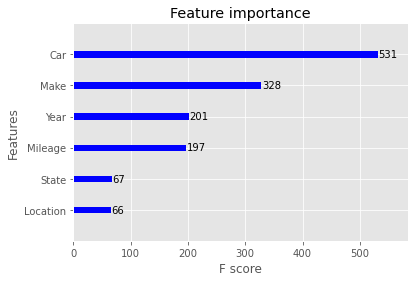

In [274]:
xgb.plot_importance(xmodel_best, color = 'blue')

The feature importance plot shows that the three most impactful features in the model is the Car (Model and Brand combined) and Make, which is the Brand of the car, and the Year the car is from. 

In [275]:
predx = xmodel_best.predict(d_test)
mean_squared_error(predx, y_test, squared = False)

7107.155439957419